In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.fftpack import fft,ifft
from glob import glob

from SinglePhotonIO import getChannels
from cont_trigger import rand_sections_wrapper, calc_psd, optimumfilt_wrapper
from pycdms.detcal.misc.cut import autocuts
from time import time

% matplotlib inline

In [2]:
fpath = sorted(glob("/galbadata/Stanford/KO15/Continuous/180612_1554*.mat"))

f = [int(ff[48:50].replace(".","")) for ff in fpath]
filepath = [x for _,x in sorted(zip(f,fpath))]

In [3]:
savepath = "testfiles/"
savename = "13180612_1554"

start = time()

n, l = 2000, 125000
t, res = rand_sections_wrapper(filepath, n, l, saveevents=True, savepath=savepath, savename=savename)
print(time()-start)

840.7455635070801


In [4]:
pt = res.sum(axis=1)
cut = autocuts(pt,fs=1.25e6)
f, psd = calc_psd(pt[cut], fs=1.25e6, folded_over=False)

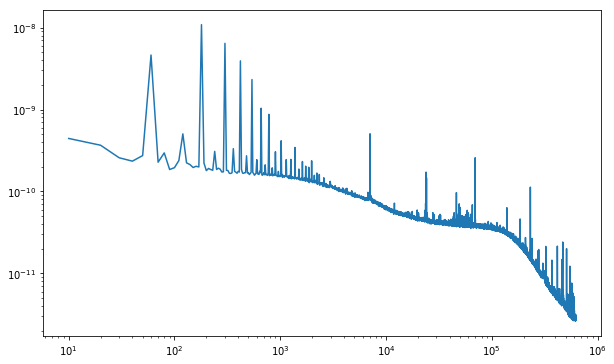

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(f[f>0],np.sqrt(2*psd[f>0]))
ax.set_yscale("log")
ax.set_xscale("log")

In [6]:
fs = 1.25e6
tracelength = 125000
# Dummy pulse template
nbin = len(psd)
ind_trigger = round(nbin/2)
timess = 1.0/fs *(np.arange(1,nbin+1)-ind_trigger)
lgc_b0= timess < 0.0

# pulse shape
tau_risepulse= 20.0e-6
tau_fallpulse= 80.0e-6
testtemplate = (1.0-np.exp(-timess/tau_risepulse))*np.exp(-timess/tau_fallpulse)
testtemplate[lgc_b0]=0.0
testtemplate = testtemplate/max(testtemplate)

In [7]:
triglen = 64
ttltime = 8e-6 # length of ttl pulse in seconds
ttllen = int(ttltime*fs)
ind_trigger = round(triglen/2)

trigtemplate = np.zeros(triglen)
trigtemplate[ind_trigger:ind_trigger+ttllen] = 1

In [8]:
thresh = 4
trigthresh = 0.8

In [9]:
start = time()
pt, pa, tt, ta, ts, types = optimumfilt_wrapper(filepath[0], testtemplate, psd, tracelength, thresh, 
                                                trigtemplate=trigtemplate,trigthresh=trigthresh, iotype="getChannels", 
                                                saveevents=True, savepath=savepath, savename=savename, dumpnum=2)
print(time()-start)

76.45191860198975
